# JumpStart: Tabular Regression using XGBoost and Linear Learner

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). 

In this demo notebook, we demonstrate how to use the JumpStart API for tabular data regression using two popular algorithms: [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). Tabular regression is the task of analyzing the relationship between predictor variables and a response variable in a structured or relational data. 

In this notebook, we demonstrate two use cases of tabular regression models:

* How to train a tabular model on an example dataset to do regression.
* How to use the trained tabular model to perform inference, i.e., predicting new samples.

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Train A Tabular Model on ABALONE Dataset](#2.-Train-a-Tabular-Model-on-ABALONE-Dataset)
    * [Retrieve Training Artifacts](#2.1.-Retrieve-Training-Artifacts)
    * [Set Training Parameters](#2.2.-Set-Training-Parameters)
    * [Start Training](#2.3.-Start-Training)
    * [Train with Automatic Model Tuning](#2.4.-Train-with-Automatic-Model-Tuning)    
3. [Deploy and Run Inference on the Trained Tabular Model](#3.-Deploy-and-Run-Inference-on-the-Trained-Tabular-Model)
4. [Evaluate the Prediction Results Returned from the Endpoint](#4.-Evaluate-the-Prediction-Results-Returned-from-the-Endpoint)

## 1. Set Up


---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [1]:
!pip install sagemaker ipywidgets --upgrade --quiet

^C
ERROR: Operation cancelled by user



---
To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Train a Tabular Model on ABALONE Dataset

---
In this demonstration, we will train a tabular algorithm on the
[ABALONE](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) dataset. 
The dataset contains examples of eight physical measurements such as length, diameter, and height to predict the age of abalone. 
Among the eight physical measurements (features), there are one categorical feature and seven numerical features. ABALONE dataset is downloaded from [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html).

Below is the screenshot of the first 5 examples in the ABALONE dataset. Note. Since [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) cannot take categorical features as input, the categorical feature with number of classes as three has been one-hot encoded into columns
from ```Feature_1``` to ```Feature_3``` as shown below.

![test_data_head.jpg](https://jumpstart-cache-prod-us-west-2.s3-us-west-2.amazonaws.com/xgboost-metadata/assets/regression_onehot_abalone_testset_head.png) 

If you want to bring your own dataset, below are the instructions on how the training data should be formatted as input to the model.

A S3 path should contain two sub-directories 'train/' and 'validation/' (optional). Each sub-directory contains a 'data.csv' file (The ABALONE dataset used in this example has been prepared and saved in `training_dataset_s3_path` shown below).
* The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data. 

>Note. For [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), the validation data is used to compute a validation score at the end of entire training process. There is no early stopping in the training process for scikit-learn linear model. If the validation data is not provided, the corresponding validation scores are not computed. 

* The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).    
* For the training and validation data, all the categorical features must be encoded as numerical values through encoding techniques such as the label encoding and one-hot encoding.

Citations:

- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science


### 2.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have two choices in this demonstration.
* [XGBoost](https://xgboost.readthedocs.io/en/latest/): To use this algorithm, specify `train_model_id` as `xgboost-regression-model` in the cell below.
* [Linear Learner](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression): To use this algorithm, specify `train_model_id` as `sklearn-regression-linear` in the cell below.

Note. [LightGBM](https://lightgbm.readthedocs.io/en/latest/) (`train_model_id: lightgbm-regression-model`) and [CatBoost](https://catboost.ai/en/docs/) (`train_model_id: catboost-regression-model`) are the other choices in the tabular regression category. Since they have different input-format requirements, please check a separate notebook `Amazon_JumpStart_Tabular_Regression_LightGBM_CatBoost.ipynb` for details.


---

In [17]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
# train_model_id, train_model_version, train_scope = "xgboost-regression-model", "*", "training"
train_model_id, train_model_version, train_scope = "sklearn-regression-linear", "*", "training"

training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 2.2. Set Training Parameters

---
Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [5]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/tabular_regressonehot/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [6]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["num_boost_round"] = "500"
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'learning_rate': '0.3', 'gamma': '0', 'min_child_weight': '1', 'max_depth': '6', 'subsample': '1', 'colsample_bytree': '1', 'reg_lambda': '1', 'reg_alpha': '0'}


### 2.3. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job.

---

In [18]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": training_dataset_s3_path}, logs=True, job_name=training_job_name)

### 2.4. Train with Automatic Model Tuning


Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs. 

In [19]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner

if train_model_id == "xgboost-regression-model":
    hyperparameter_ranges = {
        "num_round": IntegerParameter(1000, 10000),
        "lambda": IntegerParameter(1, 50),
        "colsample_bytree": ContinuousParameter(0, 1),
        "alpha": IntegerParameter(1, 50),
        "subsample": ContinuousParameter(0, 1),
        "min_child_weight": IntegerParameter(1, 50),
        "max_delta_step": IntegerParameter(1, 50),
        "gamma": IntegerParameter(1, 50),
        "eta": ContinuousParameter(0.01, 1, scaling_type="Logarithmic"),
        "max_depth": IntegerParameter(1, 10),
    }
    tuner = HyperparameterTuner(
        tabular_estimator,
        "validation:rmse",
        hyperparameter_ranges,
        max_jobs=10,
        max_parallel_jobs=2,
        objective_type="Minimize",
        base_tuning_job_name=training_job_name,
    )
elif train_model_id == "sklearn-regression-linear":
    hyperparameter_ranges = {
        "alpha": ContinuousParameter(1e-6, 1, scaling_type="Logarithmic"),
        "tol": ContinuousParameter(1e-6, 1e-1, scaling_type="Logarithmic"),
        "penalty": CategoricalParameter(["l1", "l2"]),
        "l1_ratio": ContinuousParameter(0, 1),
    }

    tuner = HyperparameterTuner(
        tabular_estimator,
        'mse',
        hyperparameter_ranges,
        [{"Name": "mse", "Regex": "mean_squared_error: ([0-9\\.]+)"}],
        max_jobs=10,
        max_parallel_jobs=2,
        objective_type=metric_definitions.get("type", "Minimize"),
        base_tuning_job_name=training_job_name,
    )

tuner.fit({"training": training_dataset_s3_path}, logs=True)

.......................................................................!


## 3. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output a numerical value to estimate the corresponding target value.

We start by retrieving the jumpstart artifacts and deploy the `tabular_estimator` that we trained.

---

In [20]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    enable_network_isolation=True,
)


2022-04-21 13:33:46 Starting - Preparing the instances for training
2022-04-21 13:33:46 Downloading - Downloading input data
2022-04-21 13:33:46 Training - Training image download completed. Training in progress.
2022-04-21 13:33:46 Uploading - Uploading generated training model
2022-04-21 13:33:46 Completed - Training job completed
-----!

---
Next, we download a hold-out ABALONE test data from the S3 bucket for inference.

---

In [21]:
jumpstart_assets_bucket = f"jumpstart-cache-prod-{aws_region}"
test_data_prefix = "training-datasets/tabular_regressonehot/test"
test_data_file_name = "data.csv"

boto3.client("s3").download_file(
    jumpstart_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name
)

---
Next, we read the ABALONE test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the ABALONE test set. All of the test examples with features 
from ```Feature_1``` to ```Feature_10``` are sent into the deployed model 
to get model predictions, to estimate the ground truth ```Target``` column. 

---

In [22]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# read the data
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(
    f"{bold}The first 5 observations of the test data: {unbold}"
)  # Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 626 examples and 11 columns.

The first 5 observations of the test data: 


,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
0,11,1.0,0.0,0.0,0.585,0.455,0.150,0.9870,0.4355,0.2075,0.3100
1,5,0.0,0.0,1.0,0.325,0.245,0.075,0.1495,0.0605,0.0330,0.0450
2,9,0.0,0.0,1.0,0.580,0.420,0.140,0.7010,0.3285,0.1020,0.2255
3,12,0.0,1.0,0.0,0.480,0.380,0.145,0.5900,0.2320,0.1410,0.2300
4,11,0.0,1.0,0.0,0.440,0.355,0.115,0.4150,0.1585,0.0925,0.1310


---
The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, ).

---

In [23]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

## 4. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the prediction results by a residual plot to compare the model predictions and ground truth targets.

* Measure the prediction results quantitatively.

---

ValueError: x and y must be the same size

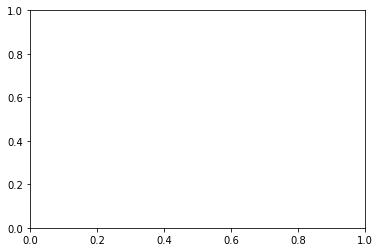

In [24]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. For each example, the residual value
# is the subtraction between the prediction and ground truth target.
# We can see that the points in the residual plot are randomly dispersed around the horizontal axis y = 0,
# which indicates the fitted regression model is appropriate for the ABALONE data

residuals = ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=0, xmin=4, xmax=18)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Residuals", fontsize=18)
plt.show()

In [ ]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [16]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()